<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# Reduce Operators with Pangeo

<img src="https://raw.githubusercontent.com/pangeo-data/pangeo.io/refs/heads/main/public/Pangeo-assets/pangeo_logo.png"
     alt="Pangeo logo"
     style="float: center; margin-right: 10px;" />

## Reduce Operators

When computing statistics over time or indices based on multiple bands, it is possible to use reduce operators.

In Pangeo and `Xarray` we can use different methods for reducing the dimensions, such as `median`, `mean` or `groupby`, which applies a reducer to a data cube dimension by collapsing all the values along the specified dimension into an output value computed by the reducer.

Reduce the temporal dimension to a single value, the mean for instance:

In [1]:
# STAC Catalogue Libraries
import pystac_client
import stackstac
import xarray as xr

In [2]:
#                  West,     South,     East,      North
spatial_extent = [11.259613, 46.461019, 11.406212, 46.522237]
temporal_extent = ["2021-05-28T00:00:00Z","2021-06-30T00:00:00Z"]

In [3]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
s2_items = catalog.search(
    bbox=spatial_extent,
    datetime=temporal_extent,
    collections=["sentinel-2-l2a"]
).item_collection()

s2_cube = stackstac.stack(s2_items,
                     bounds_latlon=spatial_extent,
                     assets=["red","nir"]
)
s2_cube

<xarray.DataArray 'stackstac-4b7e015b4bd4c4e5837fd7cd2984e9b7' (time: 26,
                                                                band: 2,
                                                                y: 714, x: 1146)> Size: 340MB
dask.array<fetch_raster_window, shape=(26, 2, 714, 1146), dtype=float64, chunksize=(1, 1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 208B 2021-...
    id                                       (time) <U24 2kB 'S2B_32TPS_20210...
  * band                                     (band) <U3 24B 'red' 'nir'
  * x                                        (x) float64 9kB 6.733e+05 ... 6....
  * y                                        (y) float64 6kB 5.155e+06 ... 5....
    created                                  (time) <U24 2kB '2023-07-19T01:3...
    ...                                       ...
    title                                    (band) <U20 160B 'Red (band 4) -...
    proj:transform                           object 8B {0, 600000, 10, 520002...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(673310.0, 5147750.0, 684770.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 673310.00|\n| 0.00,-10.00, 5154890.00|\n| 0.0...
    resolution:  10.0

### Get rid of possible negative values

In [4]:
s2_cube = xr.where(s2_cube>=0, s2_cube, 0)

Reduce the `time` dimension by averaging along the `time` dimension. Check what happens to the datacube inspecting the resulting xArray object:

In [5]:
datacube_mean_time = s2_cube.mean("time")
datacube_mean_time

<xarray.DataArray 'stackstac-4b7e015b4bd4c4e5837fd7cd2984e9b7' (band: 2,
                                                                y: 714, x: 1146)> Size: 13MB
dask.array<mean_agg-aggregate, shape=(2, 714, 1146), dtype=float64, chunksize=(1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U3 24B 'red' 'nir'
  * x                                        (x) float64 9kB 6.733e+05 ... 6....
  * y                                        (y) float64 6kB 5.155e+06 ... 5....
    mgrs:grid_square                         <U2 8B 'PS'
    instruments                              <U3 12B 'msi'
    grid:code                                <U10 40B 'MGRS-32TPS'
    ...                                       ...
    title                                    (band) <U20 160B 'Red (band 4) -...
    proj:transform                           object 8B {0, 600000, 10, 520002...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32632

It is possible to reduce in the same way all the available dimensions of the datacube.

We can, for instance, reduce the band dimension similarly as we did for the temporal dimension:

The result will now contain values resulting from the average of the bands:

In [6]:
datacube_mean_band = s2_cube.mean("band")
datacube_mean_band

<xarray.DataArray 'stackstac-4b7e015b4bd4c4e5837fd7cd2984e9b7' (time: 26,
                                                                y: 714, x: 1146)> Size: 170MB
dask.array<mean_agg-aggregate, shape=(26, 714, 1146), dtype=float64, chunksize=(1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 208B 2021-...
    id                                       (time) <U24 2kB 'S2B_32TPS_20210...
  * x                                        (x) float64 9kB 6.733e+05 ... 6....
  * y                                        (y) float64 6kB 5.155e+06 ... 5....
    created                                  (time) <U24 2kB '2023-07-19T01:3...
    s2:generation_time                       (time) <U27 3kB '2023-02-27T08:2...
    ...                                       ...
    mgrs:latitude_band                       <U1 4B 'T'
    s2:snow_ice_percentage                   (time) float64 208B 31.3 ... 6.136
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    proj:transform                           object 8B {0, 600000, 10, 520002...
    epsg                                     int64 8B 32632

**Quiz hint: look carefully at number of pixels of the loaded datacube!**

The reducer could be again a single process, but when computing spectral indices like NDVI, NDSI etc. an arithmentical formula is used instead.

For instance, the [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) formula can be expressed using a selection (`sel`) method over the `band` dimension:

$$ NDVI = {{NIR - RED} \over {NIR + RED}} $$

In [7]:
def NDVI(data):
    red = data.sel(band="red")
    nir = data.sel(band="nir")
    ndvi = (nir - red)/(nir + red)
    return ndvi

ndvi_xr = NDVI(s2_cube)
ndvi_xr

<xarray.DataArray 'stackstac-4b7e015b4bd4c4e5837fd7cd2984e9b7' (time: 26,
                                                                y: 714, x: 1146)> Size: 170MB
dask.array<truediv, shape=(26, 714, 1146), dtype=float64, chunksize=(1, 714, 1024), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 208B 2021-...
    id                                       (time) <U24 2kB 'S2B_32TPS_20210...
  * x                                        (x) float64 9kB 6.733e+05 ... 6....
  * y                                        (y) float64 6kB 5.155e+06 ... 5....
    created                                  (time) <U24 2kB '2023-07-19T01:3...
    s2:generation_time                       (time) <U27 3kB '2023-02-27T08:2...
    ...                                       ...
    mgrs:latitude_band                       <U1 4B 'T'
    s2:snow_ice_percentage                   (time) float64 208B 31.3 ... 6.136
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    proj:transform                           object 8B {0, 600000, 10, 520002...
    epsg                                     int64 8B 32632

Visualize a sample NDVI result:

/home/conda/cubes-and-clouds/daea998712cefad3ca0bba20fbb39757f32664f846901af1a1e6fd7ad3084fc0-20250115-135125-762112-523-cubes-and-clouds-new/lib/python3.11/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


CPU times: user 776 ms, sys: 140 ms, total: 917 ms
Wall time: 7.23 s


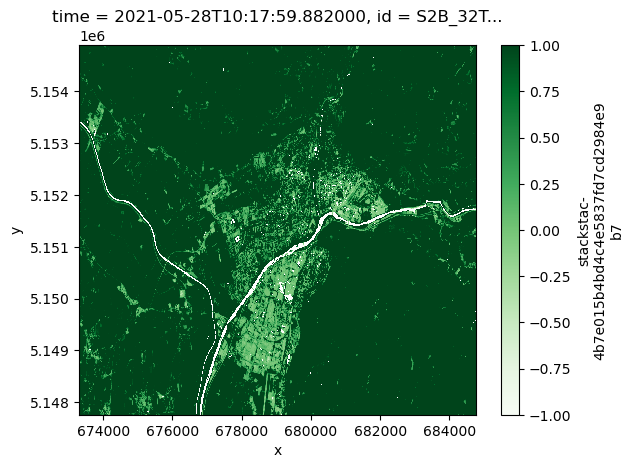

In [8]:
%%time
ndvi_xr.isel(time=0).plot.imshow(vmin=-1,vmax=1,cmap="Greens")

Additionally, it is possible to reduce both spatial dimensions of the datacube at the same time.

To do this, we need to reduce the spatial dimension using for instance `median`.

This time we select a smaller area of interest, to reduce the amount of downloaded data:

In [9]:
#                  West,     South,     East,      North
spatial_extent = [11.31369, 46.52167, 11.31906, 46.52425]
temporal_extent = ["2021-01-01T00:00:00Z","2021-12-30T00:00:00Z"]
bands = ["red","nir"]

In [10]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
s2_items = catalog.search(
    bbox=spatial_extent,
    datetime=temporal_extent,
    collections=["sentinel-2-l2a"]
).item_collection()

s2_cube = stackstac.stack(s2_items,
                     bounds_latlon=spatial_extent,
                     assets=bands
)
s2_cube = s2_cube[s2_cube["eo:cloud_cover"] < 15]

### Get rid of possible negative values

In [11]:
s2_cube = xr.where(s2_cube>=0, s2_cube, 0)

### Reduce dimension x and y with median values

In [12]:
datacube_spatial_median = s2_cube.median(dim=["x", "y"])

Verify that the spatial dimensions were collapsed:

In [13]:
datacube_spatial_median

<xarray.DataArray 'stackstac-b35ceeb12f1606b9c64ba064a8d6ee4f' (time: 65,
                                                                band: 2)> Size: 1kB
dask.array<nanmedian, shape=(65, 2), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates: (12/51)
  * time                                     (time) datetime64[ns] 520B 2021-...
    id                                       (time) <U24 6kB 'S2B_32TPS_20210...
  * band                                     (band) <U3 24B 'red' 'nir'
    created                                  (time) <U24 6kB '2023-08-30T09:5...
    s2:generation_time                       (time) <U27 7kB '2023-05-31T05:4...
    earthsearch:s3_path                      (time) <U80 21kB 's3://sentinel-...
    ...                                       ...
    title                                    (band) <U20 160B 'Red (band 4) -...
    proj:transform                           object 8B {0, 600000, 10, 520002...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32632

We can combine this spatial reducer with the previous over bands to compute a time series of NDVI values:

In [14]:
ndvi_spatial_xr = NDVI(datacube_spatial_median)
ndvi_spatial_xr

<xarray.DataArray 'stackstac-b35ceeb12f1606b9c64ba064a8d6ee4f' (time: 65)> Size: 520B
dask.array<truediv, shape=(65,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 520B 2021-...
    id                                       (time) <U24 6kB 'S2B_32TPS_20210...
    created                                  (time) <U24 6kB '2023-08-30T09:5...
    s2:generation_time                       (time) <U27 7kB '2023-05-31T05:4...
    earthsearch:s3_path                      (time) <U80 21kB 's3://sentinel-...
    processing:software                      (time) object 520B {'sentinel2-t...
    ...                                       ...
    mgrs:latitude_band                       <U1 4B 'T'
    s2:snow_ice_percentage                   (time) object 520B 53.172696 ......
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    proj:transform                           object 8B {0, 600000, 10, 520002...
    epsg                                     int64 8B 32632

In [15]:
ndvi_spatial_xr.compute()

<xarray.DataArray 'stackstac-b35ceeb12f1606b9c64ba064a8d6ee4f' (time: 65)> Size: 520B
array([1.        , 1.        , 0.72450176, 1.        , 0.69950249,
       1.        , 0.55233069, 1.        , 0.6202058 , 0.63488844,
       1.        , 0.69789227, 1.        , 0.69595376, 1.        ,
       0.70536829, 1.        , 0.71320346, 0.63970998, 1.        ,
       0.6643002 , 1.        , 0.66222645, 0.77107365, 1.        ,
       0.70346552, 0.81553398, 1.        , 0.80752841, 0.83191411,
       0.81575657, 0.82283105, 0.84372402, 1.        , 0.83625219,
       0.81262327, 1.        , 0.8295082 , 1.        , 0.84407484,
       1.        , 0.8255814 , 1.        , 0.84149419, 1.        ,
       0.82274742, 1.        , 0.70364437, 1.        , 0.82560706,
       0.77223851, 0.80659341, 1.        , 0.80912863, 0.76804734,
       0.7275    , 0.77817963, 1.        , 0.99874135, 0.86932447,
       0.82356729, 1.        , 1.        , 0.79028436, 0.78220286])
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 520B 2021-...
    id                                       (time) <U24 6kB 'S2B_32TPS_20210...
    created                                  (time) <U24 6kB '2023-08-30T09:5...
    s2:generation_time                       (time) <U27 7kB '2023-05-31T05:4...
    earthsearch:s3_path                      (time) <U80 21kB 's3://sentinel-...
    processing:software                      (time) object 520B {'sentinel2-t...
    ...                                       ...
    mgrs:latitude_band                       <U1 4B 'T'
    s2:snow_ice_percentage                   (time) object 520B 53.172696 ......
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    proj:transform                           object 8B {0, 600000, 10, 520002...
    epsg                                     int64 8B 32632

`compute()` executes the Dask computation and blocks until the result is available. It then collects and returns the final result to the local process.
In this case it will trigger the download of the data from the STAC Catalog and the computing the NDVI time series.

Visualize the NDVI time series:

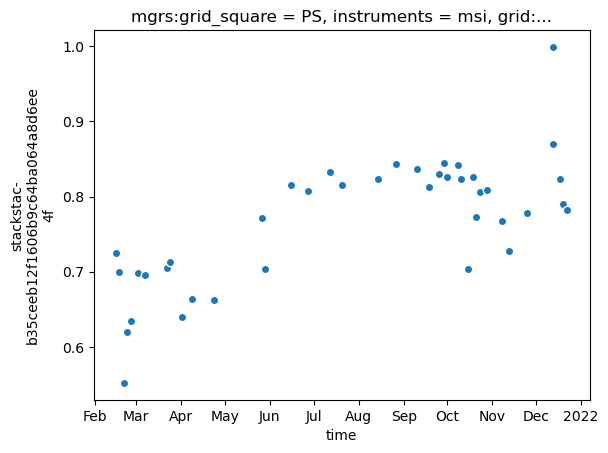

In [16]:
ndvi_spatial_xr.where(ndvi_spatial_xr<1).plot.scatter()